# WISE derived soil properties on a 30 by 30 arc-seconds global grid

**Overview**: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc

**Data files**: https://files.isric.org/public/wise/wise_30sec_v1.zip

In [4]:
import os
import pandas as pd
import numpy as np
import rasterio as rio

### function to create soil raster from mapping unit and soil prop table

In [1]:
def write_prop_raster(data_path, smu_raster, soil_df, prop_col, prop_raster):
  
    # read smu_raster
    with rio.open(os.path.join(data_path, smu_raster)) as src:
      smu_raster = src.read().squeeze()
      metadata = src.meta
      
    # convert raster to df
    smu_df = pd.DataFrame(smu_raster.flatten(), columns=['IDSMU'])
    
    # join to tabular data
    merged_df = pd.merge(smu_df, soil_df, on='IDSMU', how='left')
    # print(merged_df.head())
    
    # reconstruct raster
    soil_prop_raster = merged_df[[prop_col]].to_numpy().reshape(metadata['height'], metadata['width'])
    
    # update metadata with soil property dtype
    prop_dtype = soil_df[prop_col].dtype
  
    if prop_dtype == float:
      metadata['dtype'] = 'float32' #rasterio does not support float16
      metadata['nodata'] = np.nan
    else:
      metadata['dtype'] = 'int8' #handles drainage class (valid range 0-7)
      metadata['nodata'] = -128
      
    # set nodata values and compression
    metadata['compress'] = 'LZW'
    
    # assign metadata and write file
    with rio.open(prop_raster, 'w', **metadata) as dst:
      dst.write(soil_prop_raster, 1)

## drainage class

- group by class/category
- add proportion of components with similar class to calculate new proportion Value
- get index of max proportion and assign as drainage class for mapping unit
- note valid drainage class values are 1,2,3,4,5,6,7

In [2]:
def get_soil_Drainage(data_path, data_file):

    soil_csv = os.path.join(data_path, data_file)
    
    # read textfile
    # soil_df = pd.read_csv(soil_csv, header=0)
    soil_df = pd.read_csv(soil_csv, sep=',', header=0)
    soil_df["IDSMU"] = soil_df["NEWSUID"].str[3:].astype(int)
    soil_df = soil_df.rename(columns={"SCID" : "IDSTU"})

    # skip layers deeper than 1 meter
    soil_df = soil_df[soil_df["BotDep"] <= 100]
    
    # skip records with suid 0, 6997, 6998
    soil_df = soil_df[~soil_df["IDSMU"].isin([0, 6997, 6998])]

    sel_props = ["DrainNum"] # unique values [ 6  4  5  3  2  7 -9  1]

    # skip records with drainage class -9
    soil_df = soil_df[~soil_df["DrainNum"].isin([-9])]

    soil_df = soil_df[["IDSMU", "IDSTU", "PROP", "TopDep", "BotDep"] + sel_props]
    soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP", "DrainNum"]).agg(ROOTING_DEPTH=("BotDep", "max")).reset_index()

    # ignore ROOTING_DEPTH < 30
    soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]
    soil_df = soil_df.groupby(["IDSMU", "DrainNum"]).agg(COMBINED_PROP=("PROP", "sum")).reset_index()

    # index of rows with maximum PROP value within each group
    max_prop_index = soil_df.groupby('IDSMU')['COMBINED_PROP'].idxmax()
    
    soil_df = soil_df.loc[max_prop_index, ['IDSMU', 'DrainNum']]
    
    return soil_df[["IDSMU", "DrainNum"]]


In [ ]:
data_path = "/app/dev/AgML/soil/WISE30sec/Interchangeable_format"
data_file = "HW30s_FULL.txt"


soil_prop = get_soil_Drainage(data_path, data_file)
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop, "DrainNum", '/app/dev/AgML/soil/soil_drainage.tif')

(16753, 43201)


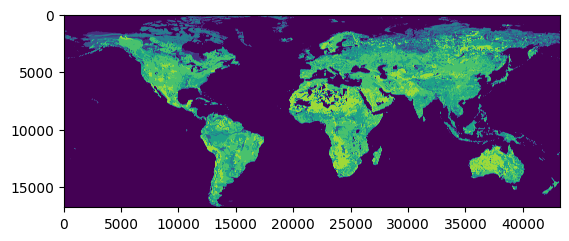

In [6]:
from matplotlib import pyplot as plt
# read smu_raster
with rio.open('/app/dev/AgML/soil/soil_drainage.tif') as src:
    smu_raster = src.read().squeeze()
    metadata = src.meta
    # print(metadata)
      
print(smu_raster.shape)
plt.imshow(smu_raster)